In [ ]:
import os, random, shutil
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [ ]:
!wget https://contestfiles.s3.eu-central-1.amazonaws.com/nyds/train.zip
!wget https://contestfiles.s3.eu-central-1.amazonaws.com/nyds/train.csv
!unzip train.zip

--2022-05-01 11:45:02--  https://contestfiles.s3.eu-central-1.amazonaws.com/nyds/train.zip
Resolving contestfiles.s3.eu-central-1.amazonaws.com (contestfiles.s3.eu-central-1.amazonaws.com)... 52.219.170.122
Connecting to contestfiles.s3.eu-central-1.amazonaws.com (contestfiles.s3.eu-central-1.amazonaws.com)|52.219.170.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 339840614 (324M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 324.10M  29.4MB/s    in 12s     

2022-05-01 11:45:15 (27.0 MB/s) - ‘train.zip’ saved [339840614/339840614]

--2022-05-01 11:45:15--  https://contestfiles.s3.eu-central-1.amazonaws.com/nyds/train.csv
Resolving contestfiles.s3.eu-central-1.amazonaws.com (contestfiles.s3.eu-central-1.amazonaws.com)... 52.219.170.150
Connecting to contestfiles.s3.eu-central-1.amazonaws.com (contestfiles.s3.eu-central-1.amazonaws.com)|52.219.170.150|:443... connected.
HTTP request sent, awaiting response... 200 

In [ ]:
import pandas as pd
data = pd.read_csv('train.csv', sep='\t')
data.head()

,image_name,class_id
0,47bb5ccde11f47579620ebefbc93a021.jpg,0
1,b00af78e10694557a74f388ee03b2273.jpg,0
2,06a78176956b474aad83d62bc787412c.jpg,0
3,c941f6970e074b7684fa458a59401850.jpg,0
4,93c5a088369846bfba05d3408f0c555b.jpg,0


In [ ]:
data.class_id.value_counts()

0    800
1    240
2    240
Name: class_id, dtype: int64

In [ ]:
#creating folders
train_dir = "/content/train"
for folder in data.class_id.unique():
  path = os.path.join(train_dir, str(folder))
  os.makedirs(path)

In [ ]:
for name, id in zip(data.image_name, data.class_id):
  path_to_img = os.path.join(train_dir, name)
  path_to_dir = os.path.join(train_dir, str(id))
  shutil.move(path_to_img, path_to_dir)

In [ ]:
#creating folders
os.mkdir('val')
val_dir = "/content/val"
for folder in data.class_id.unique():
  path = os.path.join(val_dir, str(folder))
  os.makedirs(path)

In [ ]:
def moveFile(fileDir, tarDir):
  pathDir = os.listdir(fileDir) # выберите исходный путь изображения
  filenumber = len(pathDir)
  rate = 0.3 # Настройте соотношение извлеченных изображений, например, если 100 изображений нарисовано 10, то есть 0,1
  picknumber = int(filenumber * rate) # взять определенное количество картинок из папки в соответствии с коэффициентом
  sample = random.sample(pathDir, picknumber) # случайным образом выбрать количество образцов снимков picknumber
  for name_img in sample:
    shutil.move(os.path.join(fileDir,name_img), tarDir)
  return

In [ ]:
for folder in data.class_id.unique():
  fileDir = os.path.join(train_dir, str(folder)) # Путь к папке с исходным изображением
  tarDir = os.path.join(val_dir, str(folder)) # Переместить в путь к новой папке
  moveFile(fileDir, tarDir)

In [ ]:
os.mkdir('data')

In [ ]:
shutil.move('/content/train', '/content/data')
shutil.move('/content/val', '/content/data')

'/content/data/val'

In [ ]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Сам объект датасета
data_dir = './data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [ ]:
use_gpu = torch.cuda.is_available()

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    #Ваш код здесь
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

### VGG16

In [ ]:
model_extractor = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# Ваш код здесь
model_extractor = models.vgg16(pretrained=True)

# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 3)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

Training complete in 8m 45s
Best val Acc: 0.953125


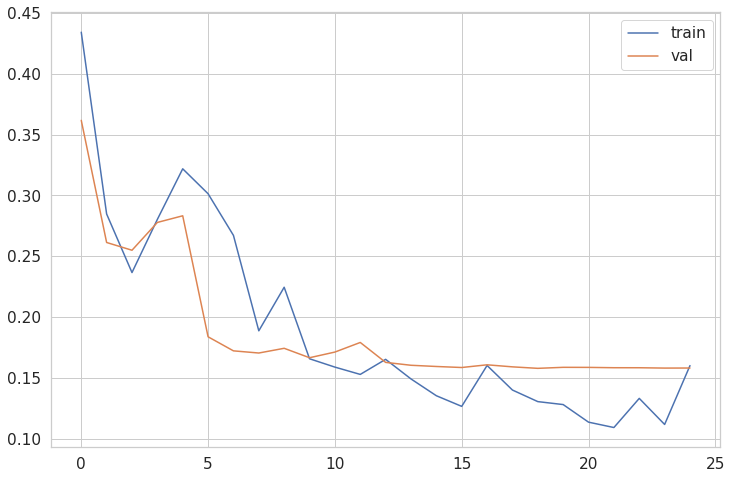

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

### InceptionV3

In [ ]:
model_extractor = models.inception_v3(pretrained=True)

In [ ]:
model_extractor.AuxLogits.fc = nn.Linear(768, 3) #заменяем слои
model_extractor.fc = nn.Linear(2048, 3) #заменяем слои

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор ?
model_extractor.classifier = nn.Linear(num_features, 3)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(model_extractor.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
%%time
model_extractor.aux_logits = False
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

train iter::   0%|          | 0/224 [00:00<?, ?it/s]

val iter::   0%|          | 0/96 [00:00<?, ?it/s]

Training complete in 15m 5s
Best val Acc: 0.973958
CPU times: user 12min 9s, sys: 35 s, total: 12min 44s
Wall time: 15min 4s


In [ ]:
torch.save(model_extractor.state_dict(), 'Inceptionv3.pth')

In [ ]:
model_extractor.load_state_dict(torch.load('Inceptionv3.pth'))

<All keys matched successfully>

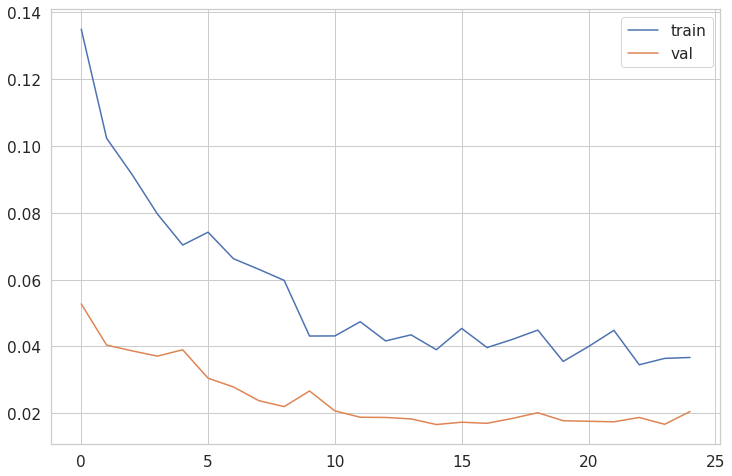

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()